# Code lab for Skripsi (Refined)

This branch implements the real world scenario of feature selection-train-cross validate-test sequence, so that the validation data does not get leaked by the feature selection method.

Feature extraction part is done in `deep_feature_extractior.ipynb` files. This file is used to feature selection and train model

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import joblib

In [2]:
label = np.array([1]*1000+[0]*1000)

In [3]:
df = pd.read_parquet('data/orig_img_feature.parquet')
df.head()

,resnet_1,resnet_2,resnet_3,resnet_4,resnet_5,resnet_6,resnet_7,resnet_8,resnet_9,resnet_10,...,resnet_51191,resnet_51192,resnet_51193,resnet_51194,resnet_51195,resnet_51196,resnet_51197,resnet_51198,resnet_51199,resnet_51200
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.028299,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,1.585785,0.0,3.971417,1.891622,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.213993,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [4]:
# split data
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

## Create Pipeline

The Pipeline will select and classify features.

Feature selection is done using `sklearn.feature_selection.SelectFromModel` with `sklearn.svm.SVC` as estimator. Feature selection and classification will run inside cross-validation.

Classification is done using SVM with linear kernel.

In [16]:
svm = SVC(kernel='linear', random_state=42)
selector = SelectFromModel(svm)
pipeline = make_pipeline(selector, svm)

## Hyperparameter tuning with Cross Validation

Find Hyperparameter C with cross validation and will be using k=10. Metrics being used is F1-Score, Recall, Precision, and Accuracy.

In [18]:
METRICS = ['f1', 'recall', 'precision', 'accuracy']
PARAM_GRID = {'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

grid = GridSearchCV(pipeline, cv=5, param_grid=PARAM_GRID, scoring=METRICS, refit=False, verbose=3)
grid.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END svc__C=0.001; accuracy: (test=0.822) f1: (test=0.819) precision: (test=0.838) recall: (test=0.801) total time= 3.1min
[CV 2/5] END svc__C=0.001; accuracy: (test=0.825) f1: (test=0.819) precision: (test=0.847) recall: (test=0.794) total time= 3.1min
[CV 3/5] END svc__C=0.001; accuracy: (test=0.803) f1: (test=0.806) precision: (test=0.794) recall: (test=0.819) total time= 3.0min
[CV 4/5] END svc__C=0.001; accuracy: (test=0.828) f1: (test=0.830) precision: (test=0.822) recall: (test=0.838) total time= 3.1min
[CV 5/5] END svc__C=0.001; accuracy: (test=0.809) f1: (test=0.796) precision: (test=0.856) recall: (test=0.744) total time= 3.0min
[CV 1/5] END svc__C=0.01; accuracy: (test=0.822) f1: (test=0.819) precision: (test=0.838) recall: (test=0.801) total time= 3.0min
[CV 2/5] END svc__C=0.01; accuracy: (test=0.825) f1: (test=0.819) precision: (test=0.847) recall: (test=0.794) total time= 3.0min
[CV 3/5] END svc__C=0.01;

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectfrommodel',
                                        SelectFromModel(estimator=SVC(kernel='linear',
                                                                      random_state=42))),
                                       ('svc',
                                        SVC(kernel='linear',
                                            random_state=42))]),
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit=False, scoring=['f1', 'recall', 'precision', 'accuracy'],
             verbose=3)

In [19]:
grid.cv_results_

{'mean_fit_time': array([168.14184532, 165.44533834, 164.7586154 , 164.81293225,
        165.10867853, 165.05418482, 164.78639278]),
 'std_fit_time': array([2.048328  , 1.07650846, 0.8649786 , 0.90354976, 1.10440764,
        0.91482389, 0.93168878]),
 'mean_score_time': array([15.57503929, 15.40841851, 15.38287816, 15.37823911, 15.41100154,
        15.37763066, 15.38993254]),
 'std_score_time': array([0.22516178, 0.14874866, 0.14590643, 0.15934065, 0.15644561,
        0.15677901, 0.16561918]),
 'param_svc__C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svc__C': 0.001},
  {'svc__C': 0.01},
  {'svc__C': 0.1},
  {'svc__C': 1},
  {'svc__C': 10},
  {'svc__C': 100},
  {'svc__C': 1000}],
 'split0_test_f1': array([0.81904762, 0.81904762, 0.81904762, 0.81904762, 0.81904762,
        0.81904762, 0.81904762]),
 'split1_test_f1': array([0.81935484, 0.8

In [20]:
cv_result = pd.DataFrame(grid.cv_results_)
cv_result.to_csv(r'result\cv_result.csv')
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,std_test_precision,rank_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,168.141845,2.048328,15.575039,0.225162,0.001,{'svc__C': 0.001},0.819048,0.819355,0.806154,0.829721,...,0.021786,1,0.821875,0.825,0.803125,0.828125,0.809375,0.8175,0.009601,1
1,165.445338,1.076508,15.408419,0.148749,0.01,{'svc__C': 0.01},0.819048,0.819355,0.806154,0.829721,...,0.021786,1,0.821875,0.825,0.803125,0.828125,0.809375,0.8175,0.009601,1
2,164.758615,0.864979,15.382878,0.145906,0.1,{'svc__C': 0.1},0.819048,0.819355,0.806154,0.829721,...,0.021786,1,0.821875,0.825,0.803125,0.828125,0.809375,0.8175,0.009601,1
3,164.812932,0.903550,15.378239,0.159341,1,{'svc__C': 1},0.819048,0.819355,0.806154,0.829721,...,0.021786,1,0.821875,0.825,0.803125,0.828125,0.809375,0.8175,0.009601,1
4,165.108679,1.104408,15.411002,0.156446,10,{'svc__C': 10},0.819048,0.819355,0.806154,0.829721,...,0.021786,1,0.821875,0.825,0.803125,0.828125,0.809375,0.8175,0.009601,1
5,165.054185,0.914824,15.377631,0.156779,100,{'svc__C': 100},0.819048,0.819355,0.806154,0.829721,...,0.021786,1,0.821875,0.825,0.803125,0.828125,0.809375,0.8175,0.009601,1
6,164.786393,0.931689,15.389933,0.165619,1000,{'svc__C': 1000},0.819048,0.819355,0.806154,0.829721,...,0.021786,1,0.821875,0.825,0.803125,0.828125,0.809375,0.8175,0.009601,1


In [22]:
cv_result[['param_svc__C', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']]

,param_svc__C,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_accuracy
0,0.001,0.814053,0.831294,0.798998,0.8175
1,0.01,0.814053,0.831294,0.798998,0.8175
2,0.1,0.814053,0.831294,0.798998,0.8175
3,1,0.814053,0.831294,0.798998,0.8175
4,10,0.814053,0.831294,0.798998,0.8175
5,100,0.814053,0.831294,0.798998,0.8175
6,1000,0.814053,0.831294,0.798998,0.8175


## Build and run the model

Because all metrics are the same on all C, we train it using the C that provide the least fit time, that is C=0.1

In [23]:
best_param_svm = SVC(kernel="linear", C=0.1, random_state=42)
best_selector = SelectFromModel(best_param_svm)
new_pipeline = make_pipeline(best_selector,
                             best_param_svm)
new_pipeline.fit(X_train, y_train)

Pipeline(steps=[('selectfrommodel',
                 SelectFromModel(estimator=SVC(C=0.1, kernel='linear',
                                               random_state=42))),
                ('svc', SVC(C=0.1, kernel='linear', random_state=42))])

In [24]:
joblib.dump(new_pipeline, r'dumps\pipeline.joblib')

['dumps\\pipeline.joblib']

### Calculate Threshold Manually

Train SVM on all X_train to calculate the threshold manually

In [6]:
train_svm = SVC(kernel='linear', C=0.1)
train_svm.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [7]:
np.savetxt(r'data\svm_coef.txt', train_svm.coef_, delimiter='\n')

In [ ]:
# np.loadtxt(r'data\svm_coef.txt')

In [8]:
print('Threshold:', np.abs(train_svm.coef_).mean())

Threshold: 0.0004338664095024176


### Get Selector and Estimator Properties

In [41]:
print('Threshold :', new_pipeline['selectfrommodel'].threshold_)

Threshold : 0.0004338664095024176


In [42]:
print('No. selected feature :', new_pipeline['selectfrommodel'].get_feature_names_out().shape)

No. selected feature : (17510,)


In [43]:
np.savetxt(r'data\svm_coef_selected.txt', new_pipeline['svc'].coef_, delimiter='\n')

## Evaluate Model

Evaluate model on test data using same metrics from cross-validation.

In [12]:
new_pipeline = joblib.load(r'dumps\pipeline.joblib')

In [16]:
y_pred = new_pipeline.predict(X_test)
true_pred_df = pd.DataFrame({'n-th sample': np.arange(1, len(y_pred)+1),
                             'y_true': np.where(y_test == 0, 'normal', 'terinfeksi'),
                             'y_pred': np.where(y_pred == 0, 'normal', 'terinfeksi')})
true_pred_df.to_csv(r'result\true_pred.csv', index=False)
true_pred_df

,n-th sample,y_true,y_pred
0,1,normal,normal
1,2,terinfeksi,terinfeksi
2,3,normal,normal
3,4,terinfeksi,terinfeksi
4,5,normal,normal
...,...,...,...
395,396,terinfeksi,normal
396,397,normal,normal
397,398,normal,normal
398,399,terinfeksi,terinfeksi


[[166  35]
 [ 45 154]]


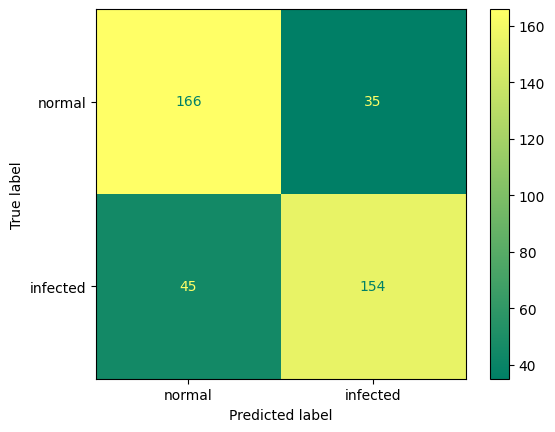

In [30]:
y_pred = new_pipeline.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['normal', 'infected'], cmap='summer')

In [33]:
metrics_list = [metrics.f1_score,
                metrics.accuracy_score,
                metrics.precision_score,
                metrics.recall_score]

for metric in metrics_list:
    print(metric.__name__ + ':', metric(y_test, y_pred))

f1_score: 0.7938144329896907
accuracy_score: 0.8
precision_score: 0.8148148148148148
recall_score: 0.7738693467336684
